In [1]:
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import numpy as np
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import sklearn
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster import hierarchy
import os
import xlrd

In [2]:
os.chdir(r'C:\Users\mkong2\OneDrive - KPMG\Documents\2022 Projects\ASX clustering\Data')

#### tidy up the data

In [ ]:
# raw_data1 = pd.ExcelFile('Horizon Scanning Constituents (1).xls')
# raw_data1 = raw_data1.parse('Screening',skiprows =6, index_col = None)
# colnames = raw_data1.iloc[0]
# raw_data1= raw_data1[1:]
# raw_data1.columns = colnames
#
# ### second file
# raw_data2 = pd.ExcelFile('Horizon Scanning Constituents (2).xls')
# raw_data2 = raw_data2.parse('Screening',skiprows =6, index_col = None)
# colnames = raw_data2.iloc[0]
# raw_data2= raw_data2[1:]
# raw_data2.columns = colnames
#
# ###### third file
# raw_data3 = pd.ExcelFile('Horizon Scanning Constituents (3).xls')
# raw_data3 = raw_data3.parse('Screening',skiprows =6, index_col = None)
# colnames = raw_data3.iloc[0]
# raw_data3= raw_data3[1:]
# raw_data3.columns = colnames

###### fourth file
raw_data5 = pd.ExcelFile('Horizon Scanning Constituents (5).xls')
raw_data5 = raw_data5.parse('Screening',skiprows =6, index_col = None)
colnames = raw_data5.iloc[0]
raw_data5= raw_data5[1:]
raw_data5.columns = colnames

In [4]:

master_data = raw_data5
#### append 3 datasets together
# master_data = raw_data1.append(raw_data2).append(raw_data3).append(raw_data4)

In [5]:
master_data.groupby(['Exchange Country/Region [Primary Listing]']).size().sort_values(ascending=False)

Exchange Country/Region [Primary Listing]
United States     3691
Canada            1109
China             1080
Japan              958
Hong Kong          882
Australia          717
United Kingdom     478
France             285
Germany            268
Italy              164
Singapore          158
Switzerland         75
Spain               71
Denmark             53
Portugal            12
-                    3
dtype: int64

#### we will have two dimensions of clustering :  one is by structure features, and the other is by performance features

In [6]:
master_data.columns

Index(['Company Name', 'Exchange:Ticker',
       'Market Capitalization [My Setting] [Latest] (USDmm, Historical rate)',
       'Total Enterprise Value [My Setting] [Latest] (USDmm, Historical rate)',
       'TEV/LTM EBITDA [My Setting] [Latest] (x)',
       'TEV/LTM Total Revenues [My Setting] [Latest] (x)', 'Primary Sector',
       'Industry Classifications', 'Altman Z Score [LTM]',
       'Revenue Surprise - Capital IQ [FY]',
       'EBITDA Surprise - Capital IQ [FY]',
       'Total Revenue [LTM - 1] (USDmm, Historical rate)',
       'Total Revenue [LTM] (USDmm, Historical rate)', 'EBITDA Margin % [LTM]',
       'Gross Margin % [LTM]', 'Net Debt/EBITDA [LTM]',
       'Total Debt/Equity % [Latest Quarter]', 'P/BV [Latest] (x)',
       'Forward P/E - Capital IQ [FY] (x)', 'Net Debt/EBITDA [LTM - 1]',
       'P/TangBV [Latest] (x)', 'Forward P/E - Capital IQ [NTM] (x)',
       'P/LTM Normalized EPS [Latest] (x)',
       'Day Close Price [Latest] (AUD, Historical rate)', 'Company Type',

In [4]:
#### only look at Australia data first
master_data= master_data[master_data['Exchange Country/Region [Primary Listing]']=='Australia']
###### structural features
# master_data_structural = master_data[['Company Name',
#                                       'Primary Sector',
#                                        'TEV/LTM EBITDA [My Setting] [Latest] (x)',
#                                        'Altman Z Score [LTM]',
#                                        'Total Debt/Equity % [Latest Quarter]',
#                                        'P/BV [Latest] (x)']]

###### Performance features
master_data_performance = master_data[['Company Name',
                                       '1 Year Beta [Latest]',
                                       'Day Close Price / 52 Week High (%) [Latest]',
                                       'Total Revenue [LTM - 1] (USDmm, Historical rate)',
                                       'Total Revenue [LTM] (USDmm, Historical rate)',
                                       'EBITDA Margin % [LTM]',
                                       'Forward P/E - Capital IQ [NTM] (x)',
                                       'Target Price - Capital IQ [Latest] (AUD, Historical rate)',
                                       'Day Close Price [Latest] (AUD, Historical rate)']]

### CLEAN DATA

In [153]:
### missing data handling
master_data_structural=master_data_structural.replace("-",np.nan) ### not available
master_data_structural=master_data_structural.replace("NM",np.nan)  ## not meaningful
print(master_data_structural.isnull().mean())
print(master_data_structural.isnull().mean())
print(master_data_structural.isnull().mean())
# master_data_performance=master_data_performance.replace("-",np.nan)
# master_data_performance=master_data_performance.replace("NM",np.nan)
# print(master_data_performance.isnull().mean())


0
Company Name                                0.000000
Primary Sector                              0.000000
TEV/LTM EBITDA [My Setting] [Latest] (x)    0.699840
Altman Z Score [LTM]                        0.282597
Total Debt/Equity % [Latest Quarter]        0.293241
P/BV [Latest] (x)                           0.076637
dtype: float64


In [154]:
# remove data if any values showing "NM"
clean_data_structural = master_data_structural[~master_data_structural.isnull().any(1)].reset_index().drop('index',axis=1)
# clean_data_performance = master_data_performance[~master_data_performance.isnull().any(1)].reset_index().drop('index',axis=1)

In [161]:
#### drop the 2 largest outliers
clean_data_structural1=clean_data_structural[clean_data_structural['Company Name']!='Intelligent Monitoring Group Limited (ASX:IMB)']
clean_data_structural2=clean_data_structural1[clean_data_structural1['Company Name']!='N1 Holdings Limited (ASX:N1H)']

<AxesSubplot:>

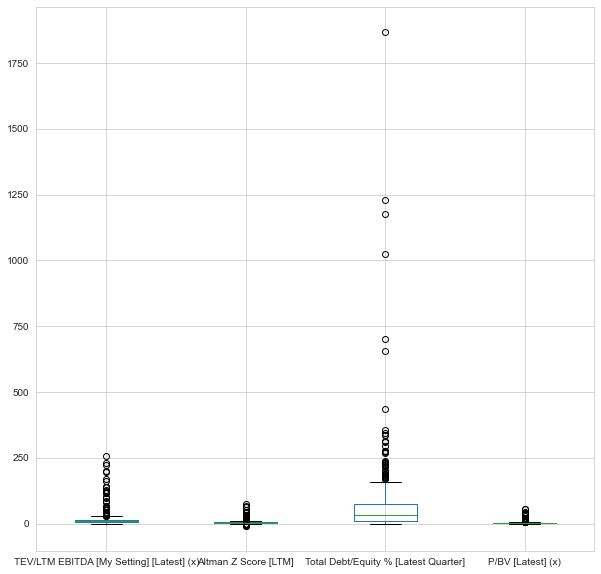

In [162]:
#####plot outliers on real data
clean_data_structural2.boxplot(['TEV/LTM EBITDA [My Setting] [Latest] (x)',
                               'Altman Z Score [LTM]',
                               'Total Debt/Equity % [Latest Quarter]',
                               'P/BV [Latest] (x)'],figsize=(10,10))

In [140]:
# clean_data_performance.boxplot(['Total Revenue [LTM - 1] (USDmm, Historical rate)',
#                                 'Total Revenue [LTM] (USDmm, Historical rate)',
#                                 'EBITDA Margin % [LTM]',
#                                 'Forward P/E - Capital IQ [NTM] (x)',
#                                 'Target Price - Capital IQ [Latest] (AUD, Historical rate)',
#                                 'Day Close Price [Latest] (AUD, Historical rate)'],figsize=(10,10))

### Standadise the data

In [163]:
###############################standardise the data #######################################################

structure_features =['TEV/LTM EBITDA [My Setting] [Latest] (x)',
                     'Altman Z Score [LTM]',
                     'Total Debt/Equity % [Latest Quarter]',
                     'P/BV [Latest] (x)' ]
# feature_only=pd.DataFrame(StandardScaler().fit_transform(clean_data1[features]))

feature_only=pd.DataFrame(MinMaxScaler(feature_range = (0, 1)).fit_transform(clean_data_structural2[structure_features]))
feature_only.columns =[ 'TEV/LTM EBITDA [My Setting] [Latest] (x)','Altman Z Score [LTM]','Total Debt/Equity % [Latest Quarter]','P/BV [Latest] (x)']


### K mean

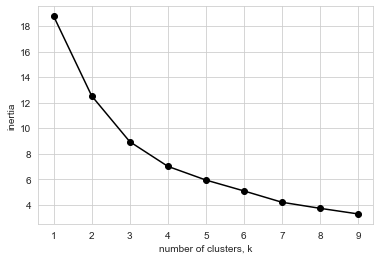

In [158]:

###################################plot elbow ##########################################################################
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(feature_only)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [165]:
kmeans = KMeans(n_clusters=3, max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(feature_only)
#Add the cluster vector to our DataFrame, X
feature_only["Cluster"] = pred_y


##### Combine the data
combined=pd.concat([feature_only,clean_data_structural2['Company Name']], axis=1, join='inner')
combined2 = clean_data_structural2.merge(combined[[ 'Company Name','Cluster']], on='Company Name', how='left')


#### output - summary stats

In [168]:
######## Summary stats
temp1 = pd.DataFrame( feature_only.groupby(['Cluster']).size())
temp2= pd.DataFrame( combined2.groupby(['Cluster'])[['TEV/LTM EBITDA [My Setting] [Latest] (x)',
                                'Altman Z Score [LTM]',
                                'Total Debt/Equity % [Latest Quarter]',
                                'P/BV [Latest] (x)']].agg('mean'))

In [170]:
temp3 = temp1.merge(temp2, on='Cluster', how='left')


### Visualization

In [172]:

#########################################################Visualization ###################################################

#PCA with two principal components
pca_2d = decomposition.PCA(n_components=2)
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(feature_only))

PCs_2d.columns = ["PC1_2d", "PC2_2d"]
plotX = pd.concat([feature_only,PCs_2d], axis=1, join='inner')
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
    x = cluster0["PC1_2d"],
    y = cluster0["PC2_2d"],
    mode = "markers",
    name = "Cluster 0",
    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
    x = cluster1["PC1_2d"],
    y = cluster1["PC2_2d"],
    mode = "markers",
    name = "Cluster 1",
    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
    x = cluster2["PC1_2d"],
    y = cluster2["PC2_2d"],
    mode = "markers",
    name = "Cluster 2",
    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
    text = None)



data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )

fig = dict(data = data, layout = layout)

plot(fig)



'temp-plot.html'